In [1]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
from scipy.spatial.distance import cdist

In [2]:
import sys
sys.path += ["../src"]
import config
import utils
from glob import glob
import gzip
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots as sbp
import json

In [3]:
def save_gz(url, fn, city):
    resp = requests.get(url + "data/" + fn)
    resp.raise_for_status()
    path_city = config.INTERMEDIATE_DATA_PATH + "airbnb/" + city
    if not os.path.exists(path_city):
        os.mkdir(path_city)

    with open(path_city + "/" + fn, "wb") as f:
        f.write(resp.content)

def read_gz(city, fn):
    return pd.read_csv(gzip.open(config.INTERMEDIATE_DATA_PATH + "airbnb/" + city + "/" + fn, mode='rb'))

def save_json(url, city):
    resp = requests.get(url + "visualisations/neighbourhoods.geojson")
    resp.raise_for_status()
    path_city = config.INTERMEDIATE_DATA_PATH + "airbnb/" + city
    with open(path_city + "/neighbourhoods.geojson", "wb") as f:
        f.write(resp.content)

def read_json(city):
    path_city = config.INTERMEDIATE_DATA_PATH + "airbnb/" + city
    gdf = gpd.read_file(path_city + "/neighbourhoods.geojson")
    return gdf


In [4]:
airbnb_path = "/data/housing/data/intermediate/jl_pop_synth/airbnb/"

In [5]:
# https://insideairbnb.com/get-the-data/

# city = "copenhagen"
# url = "https://data.insideairbnb.com/denmark/hovedstaden/copenhagen/2025-03-23/"

# city = "brisbane"
# url = "https://data.insideairbnb.com/australia/qld/brisbane/2025-06-09/"

# city = "hawaii"
# url = "https://data.insideairbnb.com/united-states/hi/hawaii/2025-03-06/"

# city = "naples"
# url = "https://data.insideairbnb.com/italy/campania/naples/2025-06-19/"

# city = "rome"
# url = "https://data.insideairbnb.com/italy/lazio/rome/2025-03-05/"

# city = "paris"
# url = "https://data.insideairbnb.com/france/ile-de-france/paris/2025-06-06/"

# city = "barcelona"
# url = "https://data.insideairbnb.com/spain/catalonia/barcelona/2025-06-12/"

In [6]:
# save_gz(url = url, 
#         fn = "listings.csv.gz", 
#         city = city)

# save_json(url = url, 
#           city = city)

In [10]:
city = "naples"
df_full = read_gz(city, fn = "/listings.csv.gz")
gdf_full = read_json(city)
df_full["amenities"] = [json.loads(u) for u in df_full["amenities"]]

In [11]:
amenities_vars = ["Air conditioning", "Elevator", "Self check-in", "Pets allowed", "Private living room", "Backyard", "Pool"]

In [12]:
for var in amenities_vars:
    df_full[var] = [var in u for u in df_full["amenities"]]

In [13]:
df = df_full[['id', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'price',
       'review_scores_rating', 'reviews_per_month'] + amenities_vars].rename(columns = {"latitude": "y", "longitude": "x"})

In [14]:
gdf = gdf_full[["neighbourhood","geometry"]].dissolve().to_crs('EPSG:4326')

In [15]:
len(df)

10669

Text(0.5, 1.0, 'naples')

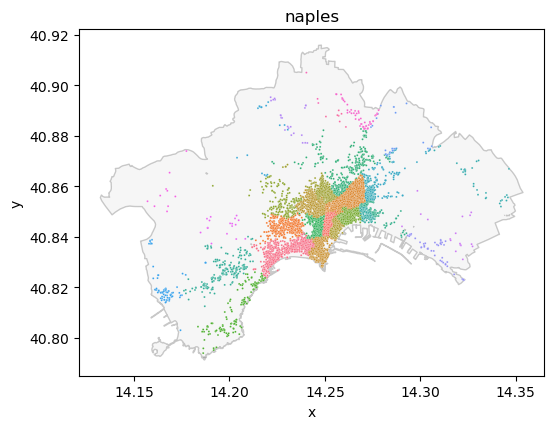

In [16]:
fig, axes = sbp(figsize = (6,6))
gdf["geometry"].plot(ax = axes, color = "lightgrey", alpha = 0.2, edgecolor = "black")
sns.scatterplot(data = df, x = "x", y = "y", 
                hue = "neighbourhood_cleansed",
                s = 2,
                ax = axes)

axes.legend().set_visible(False)
axes.set_title(city)

### Synthetic population

In [17]:
date = "250703"

In [18]:
glob(airbnb_path + f"pop_samples/synthetic_pop_*_{date}.csv")

['/data/housing/data/intermediate/jl_pop_synth/airbnb/pop_samples/synthetic_pop_naples_250703.csv',
 '/data/housing/data/intermediate/jl_pop_synth/airbnb/pop_samples/synthetic_pop_copenhagen_250703.csv',
 '/data/housing/data/intermediate/jl_pop_synth/airbnb/pop_samples/synthetic_pop_hawaii_250703.csv',
 '/data/housing/data/intermediate/jl_pop_synth/airbnb/pop_samples/synthetic_pop_in_polygon_hawaii_250703.csv',
 '/data/housing/data/intermediate/jl_pop_synth/airbnb/pop_samples/synthetic_pop_brisbane_250703.csv']

In [ ]:
df_real = df.dropna().assign(price_num = lambda x: [float(u[1:].split(".")[0].replace(",", "")) for u in x["price"]]).assign(log_price = lambda x: np.log(x["price_num"]))

if os.path.exists(airbnb_path + f"pop_samples/synthetic_pop_in_polygon_{city}_{date}.csv"):
    df_sample = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_in_polygon_{city}_{date}.csv", index_col = 0)
else:
    df_sample = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}.csv", index_col = 0)

    gdf_sample = gpd.GeoDataFrame(df_sample, geometry = gpd.points_from_xy(df_sample["x"], df_sample["y"])) 
    ## slow
    
    obs_in_city = gdf_sample.within(gdf_full["geometry"].union_all())
    df_sample = df_sample.loc[obs_in_city]
    # this is faster
    # gpd.tools.sjoin(df_valid, census, predicate="within", how='left')
    # gdf.within(gdf_full["geometry"])

    df_sample = df_sample.query("(review_scores_rating >= 0)&(review_scores_rating <= 5)&(reviews_per_month > 0)").sample(n = len(df_real), random_state = 10075)
    for var in [u for u in amenities_vars]:
        df_sample[var] = df_sample[var] > df_sample[var].quantile(1 - df_full[var].astype(np.float32).mean())

    df_sample[["accommodates","bathrooms","bedrooms","beds"]] = df_sample[["accommodates","bathrooms","bedrooms","beds"]].astype(int)
    df_sample.to_csv(airbnb_path + f"pop_samples/synthetic_pop_in_polygon_{city}_{date}.csv")


In [22]:
df_sample.iloc[0]

accommodates                        8
bathrooms                           1
bedrooms                            2
beds                                4
review_scores_rating         4.840619
reviews_per_month            1.175011
Air conditioning                 True
Elevator                        False
Self check-in                   False
Pets allowed                    False
Private living room             False
Backyard                        False
Pool                            False
log_price                    4.800863
roomtype_Entire home/apt         True
roomtype_Hotel room             False
roomtype_Private room           False
roomtype_Shared room            False
y_latent                     0.339375
x_latent                     0.370781
x_norm                        -0.0492
y_norm                      -0.028131
x                           14.248622
y                           40.847885
Name: 99646, dtype: object

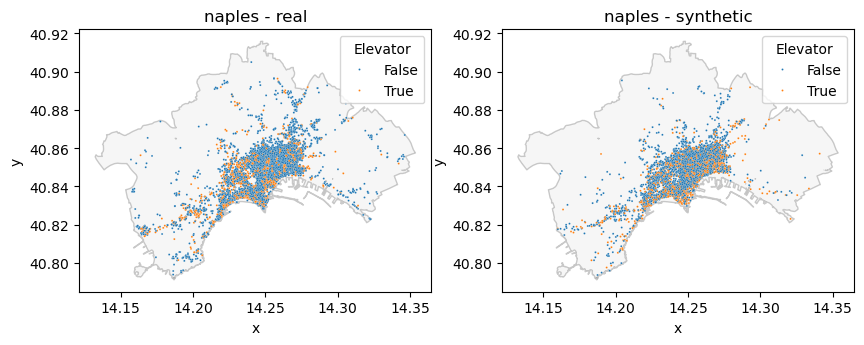

In [33]:
fig, axes = sbp(ncols = 2, figsize = (10,5))

for j, df_ in enumerate([df, df_sample]):
    gdf["geometry"].plot(ax = axes[j], color = "lightgrey", alpha = 0.2, edgecolor = "black")
    sns.scatterplot(data = df_, x = "x", y = "y", 
                    # hue = "log_price",
                    hue = "Elevator",
                    # palette = "YlOrRd",
                    # hue_norm = (6., 9.),
                    # hue_norm = (4., 5.),
                    s = 2,
                    ax = axes[j])

    axes[j].set_title([city + " - " + u for u in ["real", "synthetic"]][j])

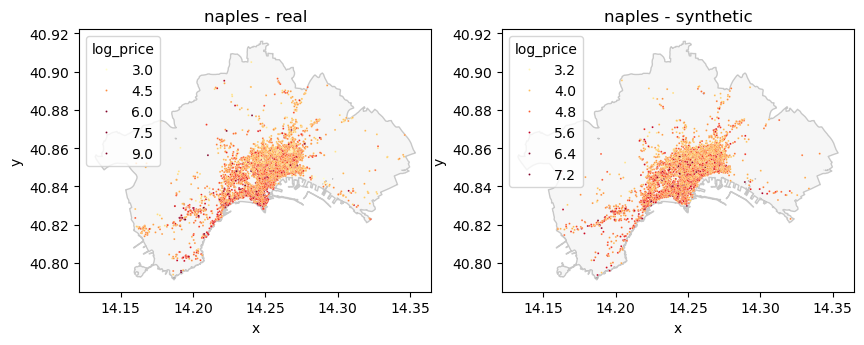

In [34]:
fig, axes = sbp(ncols = 2, figsize = (10,5))

for j, df_ in enumerate([df_real, df_sample]):
    gdf["geometry"].plot(ax = axes[j], color = "lightgrey", alpha = 0.2, edgecolor = "black")
    sns.scatterplot(data = df_, x = "x", y = "y", 
                    hue = "log_price",
                    # hue = "Elevator",
                    palette = "YlOrRd",
                    hue_norm = (3., 6.),
                    s = 2,
                    ax = axes[j])

    axes[j].set_title([city + " - " + u for u in ["real", "synthetic"]][j])

ValueError: Could not interpret value `log_price` for `hue`. An entry with this name does not appear in `data`.

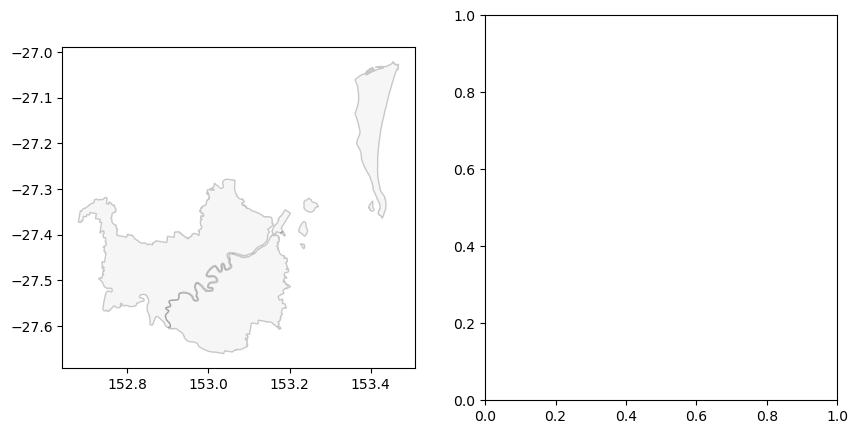

In [125]:
fig, axes = sbp(ncols = 2, figsize = (10,5))

for j, df_ in enumerate([df, df_sample]):
    gdf["geometry"].plot(ax = axes[j], color = "lightgrey", alpha = 0.2, edgecolor = "black")
    sns.scatterplot(data = df_, x = "x", y = "y", 
                    hue = "log_price",
                    palette = "YlOrRd",
                    hue_norm = (6., 9.),
                    s = 2,
                    ax = axes[j])

    axes[j].set_title([city + " - " + u for u in ["real", "synthetic"]][j])